In [3]:
# MISC
import os
import sys

sys.path.append("..")
os.environ['MUJOCO_GL']='egl'
os.environ['CUDA_VISIBLE_DEVICES']='0'

# import shutups
# shutup.please()

import jax
import jax.numpy as jnp

import numpy as np
from functools import partial

# VIS
import matplotlib
import matplotlib.pyplot as plt
import mediapy
from rich.pretty import pprint
from tqdm.auto import tqdm

from hydra import initialize, compose
from omegaconf import OmegaConf

plt.style.use(['seaborn-v0_8-colorblind', 'seaborn-v0_8-notebook'])
colors = plt.rcParams['axes.prop_cycle'].by_key()['color'] 

GLOBAL_KEY = jax.random.key(42)

,,,

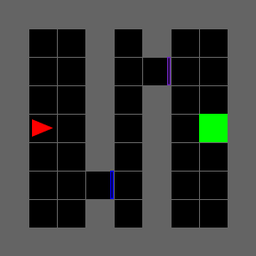
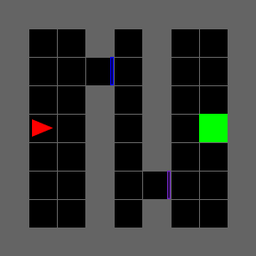
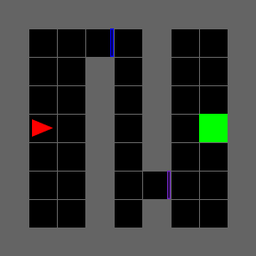
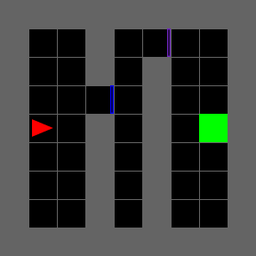

In [4]:
from envs.minigrid.doors_grid import DynamicsGeneralization_Doors, MinigridWrapper

# Train dynamics
layouts = []
for i in [0, 1, 2, 3]:
    env = DynamicsGeneralization_Doors(render_mode="rgb_array", highlight=False, max_steps=100, task_num=0)
    env._gen_grid = partial(env._gen_grid, layout_type=i)
    env = MinigridWrapper(env)
    # env = ActionRepeatWrapper(env, action_repeat=3) # test
    env.reset()
    
    layouts.append(env.render())
    
mediapy.show_images(layouts, width=256, height=256)

  0%|          | 0/5 [00:00<?, ?it/s]

{
│   'actions': (196000,),
│   'layout_type': (196000, 5),
│   'next_observations': (196000, 2),
│   'observations': (196000, 2),
│   'terminals': (196000,)
}

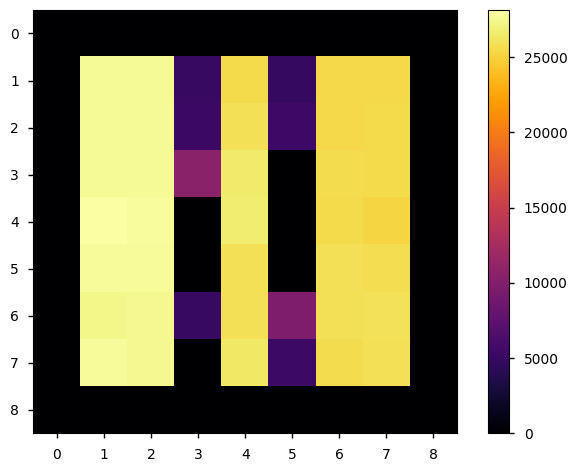

In [5]:
from envs.minigrid.env_utils import random_exploration

train_layout_data = []

NUM_TRAIN_LAYOUTS = 5
NUM_TRAIN_STEPS = 99
NUM_TRAIN_EPISODES = 2000

for i in tqdm(range(NUM_TRAIN_LAYOUTS)):
    env = DynamicsGeneralization_Doors(render_mode="rgb_array", highlight=False, max_steps=NUM_TRAIN_STEPS, agent_start_pos=None) # comment agent_start_pos for same start pos
    env._gen_grid = partial(env._gen_grid, layout_type=i)
    env = MinigridWrapper(env)
    dataset, env = random_exploration(env, num_episodes=NUM_TRAIN_EPISODES, layout_type=i, num_mdp=NUM_TRAIN_LAYOUTS)
    train_layout_data.append(dataset)

pprint(jax.tree.map(lambda x: x.shape, train_layout_data[0]))

coverage_map = np.zeros(shape=(env.env.unwrapped.width, env.env.unwrapped.height))
for layout in train_layout_data:
    for obs in layout['observations']:
        obs = obs.astype(np.int16)
        coverage_map[obs[1], obs[0]] += 1
        
plt.imshow(coverage_map, cmap='inferno', vmin=0)
plt.colorbar()
plt.show()

In [6]:
import functools
from utils.datasets import Dataset, GCDataset

with initialize(version_base=None, config_path="../configs/"):
    fb_config = compose(config_name='entry.yaml', overrides=['experiment=fb_vanilla_discrete_4rooms.yaml'])
    fb_config = OmegaConf.to_container(fb_config, resolve=True)
    pprint(fb_config)

def concatenate_dicts(dict1, dict2):
    return jax.tree.map(lambda x, y: jnp.concatenate([x, y]), dict1, dict2)

whole_data = functools.reduce(concatenate_dicts, train_layout_data)

print(jax.tree.map(lambda x: x.shape, whole_data))
whole_dataset = Dataset.create(**jax.device_get(whole_data))
gc_whole_dataset = GCDataset(whole_dataset, config=fb_config['agent'])

{
│   'seed': 42,
│   'run_group': 'fb',
│   'save_dir': 'experiment_logs/',
│   'train_steps': 150000,
│   'log_interval': 10000,
│   'eval_interval': 30000,
│   'eval_tasks': None,
│   'eval_episodes': 20,
│   'eval_temperature': 0,
│   'eval_gaussian': None,
│   'video_episodes': 1,
│   'video_frame_skip': 3,
│   'eval_on_cpu': 0,
│   'frame_stack': None,
│   'p_aug': None,
│   'agent': {
│   │   'agent_name': 'fb',
│   │   'lr': 0.0003,
│   │   'batch_size': 1024,
│   │   'discrete': True,
│   │   'discount': 0.99,
│   │   'tau': 0.01,
│   │   'clip_by_global_norm': True,
│   │   'dataset_class': 'GCDataset',
│   │   'value_p_curgoal': 0.0,
│   │   'value_p_trajgoal': 1.0,
│   │   'value_p_randomgoal': 0.0,
│   │   'value_geom_sample': True,
│   │   'actor_p_curgoal': 0.0,
│   │   'actor_p_trajgoal': 0.0,
│   │   'actor_p_randomgoal': 1.0,
│   │   'actor_geom_sample': False,
│   │   'gc_negative': True,
│   │   'p_aug': 0.0,
│   │   'frame_stack': None,
│   │   'z_dim': 100,
│   │   'z_mix_ratio': 0.5,
│   │   'boltzmann': True,
│   │   'f_hidden_dims': [1024, 512, 512],
│   │   'f_layer_norm': True,
│   │   'b_hidden_dims': [512, 512, 512],
│   │   'b_layer_norm': True,
│   │   'use_context': False
│   },
│   'env': {'env_name': 'fourrooms-vanilla', 'discrete': True},
│   'tags': ['vanilla-fb', '4rooms', 'discrete']
}

{'actions': (980000,), 'layout_type': (980000, 5), 'next_observations': (980000, 2), 'observations': (980000, 2), 'terminals': (980000,)}


In [7]:
sys.path.append("..")
from agents.fb import ForwardBackwardAgent

gc_whole_dataset = GCDataset(whole_dataset, config=fb_config['agent'])
example_batch = gc_whole_dataset.sample(1)
fb_agent = ForwardBackwardAgent.create(
    0,
    example_batch['observations'],
    np.full_like(example_batch['actions'], env.action_space.n - 1),
    config=fb_config['agent']
)
fb_agent, info = fb_agent.update(gc_whole_dataset.sample(512))

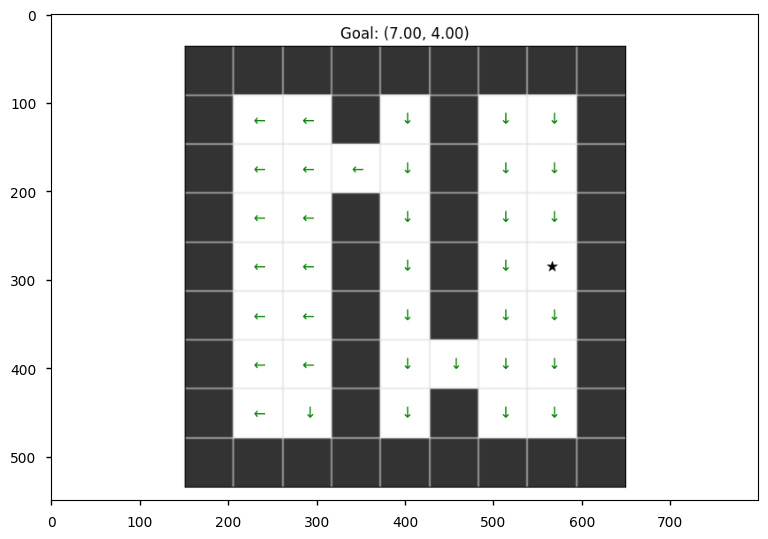

In [14]:
from functools import partial
from utils.evaluation import supply_rng
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

def get_canvas_image(canvas):
    canvas.draw() 
    out_image = np.asarray(canvas.buffer_rgba())
    return out_image

def policy_image_grid(env, dataset, action_fn=None, **kwargs):
    fig = plt.figure(tight_layout=True)
    canvas = FigureCanvas(fig)
    plot_policy(env, dataset, fig=fig, ax=plt.gca(), action_fn=action_fn, **kwargs)
    image = get_canvas_image(canvas)
    plt.close(fig)
    return image

def plot_policy(env, dataset, fig=None, ax=None, title=None, action_fn=None, **kwargs):
    action_names = [
            r'$\leftarrow$', r'$\rightarrow$', r'$\uparrow$', r'$\downarrow$'
        ]
    if fig is None or ax is None:
        fig, ax = plt.subplots()
    
    grid = env.get_grid_array()
    ax = env.plot_grid(ax=ax, grid=grid)
    
    goal = kwargs.get('goal', None)
    for (y, x), value in np.ndenumerate(grid):
        if value == 1 or value == 4:
            action = action_fn(np.concatenate([[x], [y]], -1)).squeeze()
            action_name = action_names[action]
            ax.text(x, y, action_name, ha='center', va='center', fontsize='large', color='green')
            
    ax.set_title('Goal: ({:.2f}, {:.2f})'.format(goal[0], goal[1])) 
    ax.scatter(goal[0], goal[1], s=80, c='black', marker='*')
        
    if title:
        ax.set_title(title)
        
    return fig, ax

def visualize_policy_image(layout_type, task_num):
    mdp_type = np.zeros((NUM_TRAIN_LAYOUTS, ))
    if mdp_type is not None:
        if layout_type == 0:
            mdp_type[0] = 1
        elif layout_type == 1:
            mdp_type[1] = 1
        else:
            mdp_type[2] = 1

    env = DynamicsGeneralization_Doors(render_mode="rgb_array", highlight=False,
                                    max_steps=NUM_TRAIN_STEPS, task_num=task_num)
    env._gen_grid = partial(env._gen_grid, layout_type=layout_type)
    env = MinigridWrapper(env)
    dynamics_embedding=None
    obs, info = env.reset()
    goal = info.get("goal_pos", None)
    
    latent_z = jax.device_get(fb_agent.infer_z(goal)[None])
    example_batch = gc_whole_dataset.sample(1)
    pred_policy_img = policy_image_grid(env, example_batch,
                                                    action_fn=partial(supply_rng(fb_agent.sample_actions,
                                                                                rng=jax.random.PRNGKey(np.random.randint(0, 2**32))), latent_z=latent_z,
                                                                temperature=0.0),
                                                    goal=goal)
    return pred_policy_img

pred_policy_img = visualize_policy_image(layout_type=1, task_num=0)
plt.imshow(pred_policy_img)
plt.tight_layout()

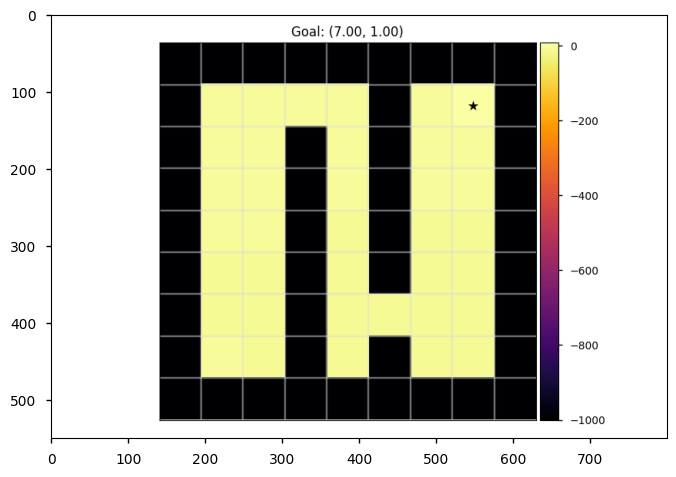

In [16]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def value_image_fourrooms(env, dataset, value_fn, action_fn=None, **kwargs):
    fig = plt.figure(tight_layout=True)
    canvas = FigureCanvas(fig)
    plot_value_image_grid(env, dataset, value_fn, fig=fig, ax=plt.gca(), action_fn=action_fn, **kwargs)
    image = get_canvas_image(canvas)
    plt.close(fig)
    return image

def plot_value_image_grid(env, dataset, value_fn, action_fn, fig=None, ax=None, title=None, **kwargs):
    if fig is None or ax is None:
        fig, ax = plt.subplots()
    
    goal = kwargs.get('goal', None)
    grid = env.get_grid_array()
    ax = env.plot_grid(ax=ax, grid=grid)

    for (y, x), value in np.ndenumerate(grid):
        if value == 1 or value == 4:
            grid[y, x] = jax.device_get(value_fn(np.concatenate([[x], [y]], -1)).max(-1)[0])
            
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    im = ax.imshow(grid, cmap='inferno', vmin=-1000)
    fig.colorbar(im, cax=cax, orientation='vertical')
    if goal is not None:
        ax.set_title('Goal: ({:.2f}, {:.2f})'.format(goal[0], goal[1])) 
        ax.scatter(goal[0], goal[1], s=80, c='black', marker='*')
    return fig, ax

def visualize_value_image(layout_type, task_num):
    mdp_type = None
    env = DynamicsGeneralization_Doors(render_mode="rgb_array", highlight=False,
                                    max_steps=NUM_TRAIN_STEPS, task_num=task_num)
    env._gen_grid = partial(env._gen_grid, layout_type=layout_type)
    env = MinigridWrapper(env)
    dynamics_embedding=None
    obs, info = env.reset()
    goal = info.get("goal_pos", None)
    
    latent_z = jax.device_get(fb_agent.infer_z(goal)[None])
    pred_value_img = value_image_fourrooms(env, example_batch,
                                value_fn=partial(fb_agent.predict_q, z=latent_z),
                                action_fn=None, goal=goal)
    return pred_value_img

pred_value_img = visualize_value_image(2, task_num=1)
plt.imshow(pred_value_img)


In [17]:
pbar = tqdm(range(100_000))

for update_step in pbar:
    batch = gc_whole_dataset.sample(1024)
    fb_agent, info = fb_agent.update(batch)
    
    if update_step % 5_000 == 0:
        clear_output()
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
        pred_policy_img = visualize_policy_image(task_num=0)
        ax[0].imshow(pred_policy_img)
        pred_value_img = visualize_value_image(task_num=0)
        ax[1].imshow(pred_value_img)
        
        fig.suptitle(f"Training step: {update_step}")   
        plt.tight_layout()
        display(fig)
        plt.close(fig)

  0%|          | 0/100000 [00:00<?, ?it/s]

NameError: name 'clear_output' is not defined

In [ ]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

# Visualization for 3D case
def visualize_3d(z_pre, z_post, anchor):
    fig = plt.figure(figsize=(12, 6))
    
    # Pre-rotation
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.scatter(z_pre[:,0], z_pre[:,1], z_pre[:,2], alpha=0.6)
    ax1.quiver(0, 0, 0, 1, 0, 0, color='r', lw=2, label='Original Direction')
    ax1.set_title('Pre-Rotation Samples')
    ax1.set_xlim(-1,1); ax1.set_ylim(-1,1); ax1.set_zlim(-1,1)
    
    # Post-rotation
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.scatter(z_post[:,0], z_post[:,1], z_post[:,2], alpha=0.6, c='orange')
    # ax2.quiver(0, 0, 0, *anchor, color='g', lw=2, label='Target Anchor')
    ax2.set_title(f'Post-Rotation Samples (κ=50)')
    ax2.set_xlim(-1,1); ax2.set_ylim(-1,1); ax2.set_zlim(-1,1)
    
    plt.tight_layout()
    plt.show()
    
def get_colors_by_composite_labels(labels: np.ndarray):
    """
    Assign colors based on composite labels (arrays of size 3).
    Each unique combination of 3 values gets the same color.
    
    Args:
        labels: numpy array of shape (batch, 3) where each row is a composite label
        
    Returns:
        List of color strings in hex format
    """
    cmap = matplotlib.colormaps['Set1']
    color_palette = cmap(np.linspace(0, 1, 3)) # number of doors
    
    # Convert each composite label to a tuple (hashable) for dictionary keys
    label_tuples = [tuple(label) for label in labels]
    unique_labels = list(set(label_tuples))  # Get unique composite labels
    
    # Create mapping from composite label to color
    label_to_color = {label: color_palette[i % len(color_palette)] 
                    for i, label in enumerate(unique_labels)}
    
    # Generate color array
    colors = [label_to_color[tuple(label)] for label in labels]
    
    return colors

def visualize_dynamics(z_pres, z_posts, anchor, z_colors, colors):
    fig = plt.figure(figsize=(12, 6))
    anchor = (anchor / jnp.linalg.norm(anchor, axis=-1, keepdims=True))
    ax1 = fig.add_subplot(111, projection='3d')
    for i in range(z_pres.shape[0]):
        ax1.scatter(z_pres[i,:, 0], z_pres[i,:, 1], z_pres[i, :, 2], alpha=0.6, c=z_colors[i])#c[i])
    for i in range(1, colors.shape[0]):
        ax1.quiver(0, 0, 0, *anchor[i], color=colors[i], lw=2)
    ax1.set_title('Pre-Rotation Samples')
    ax1.set_xlim(-1,1); ax1.set_ylim(-1,1); ax1.set_zlim(-1,1)
    
    plt.tight_layout()
    plt.show()

def project_z(z):
    return z / jnp.linalg.norm(z, axis=-1, keepdims=True)

def sample_z(batch_size, latent_dim, key):
    z = jax.random.normal(shape=(batch_size, latent_dim), key=key)
    return z

final_indices = np.cumsum(jnp.array([layouts_for_embeddings[i]['traj_states'].shape[0] for i in range(len(layouts_for_embeddings))]))
samples_from_trajs = []
prev_inxs = 0
for i in range(len(final_indices)):
    cur_sel = np.random.choice(np.arange(prev_inxs, final_indices[i]), size=35)
    samples_from_trajs.append(cur_sel)
    prev_inxs = final_indices[i] + 1
    
samples_from_trajs_indxs = np.stack(samples_from_trajs).reshape(-1)
    
sphere_directions = sample_z(2048, fb_config['agent']['z_dim'], GLOBAL_KEY)
projected_sphere_dirs = project_z(PCA(3, random_state=42).fit_transform(sphere_directions))

F1, F2 = fb_agent.network.select('f_value')(jnp.repeat(jnp.array([4, 1])[None], repeats=sphere_directions.shape[0], axis=0), 
                                        sphere_directions, jnp.repeat(dynamics_embedding[3][None], repeats=sphere_directions.shape[0], axis=0))
Q1 = jnp.einsum('sda, sd -> sa', F1, sphere_directions)
Q2 = jnp.einsum('sda, sd -> sa', F2, sphere_directions)
Q = jnp.minimum(Q1, Q2)
best_actions = jnp.argmax(Q, axis=-1)


fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
cmap = plt.get_cmap('tab10')
colors = cmap(best_actions / 4)
ax.scatter(
    projected_sphere_dirs[:, 0],
    projected_sphere_dirs[:, 1],
    projected_sphere_dirs[:, 2],
    c=colors,
    s=20,
    alpha=0.8
)
ax.set_title('Decision Boundary of F on the Unit Sphere')
ax.set_xlim(-1, 1); ax.set_ylim(-1, 1); ax.set_zlim(-1, 1)
plt.show()